In [703]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error  
import requests
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, RandomizedSearchCV
import pickle


In [704]:
df = pd.read_parquet('/Users/laceymorgan/Desktop/energy_consumption_xgb_model/est_hourly.paruqet')
df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


In [705]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [706]:
df.isnull().sum()

AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

In [707]:
# bring Datetime index to column
df.reset_index(inplace=True)

In [708]:
df.dtypes

Datetime    datetime64[ns]
AEP                float64
COMED              float64
DAYTON             float64
DEOK               float64
DOM                float64
DUQ                float64
EKPC               float64
FE                 float64
NI                 float64
PJME               float64
PJMW               float64
PJM_Load           float64
dtype: object

In [709]:
#Show all the PJM Regions. These are grouped into PJM East and PJM West
from IPython.display import Image
Image(url= "http://slideplayer.com/4238181/14/images/4/PJM+Evolution.jpg")

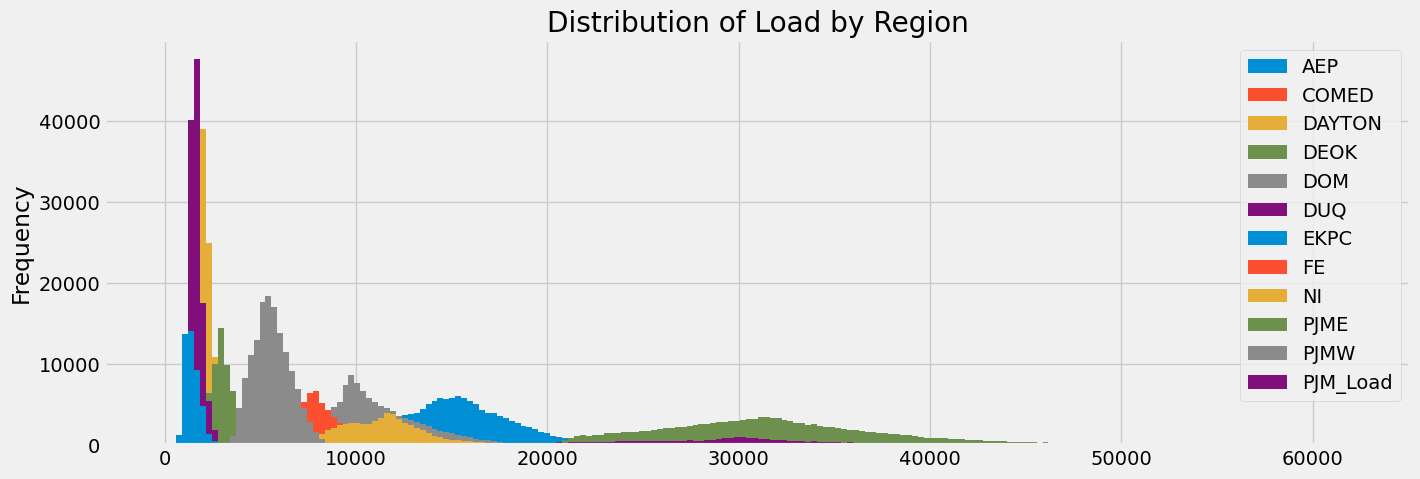

In [710]:
# Looking at distribution of load by region
df.plot.hist(figsize=(15, 5), bins=200, title='Distribution of Load by Region')
plt.show()

### Plotting timeseries

In [711]:
# set datetime as index
df.set_index('Datetime', inplace=True)

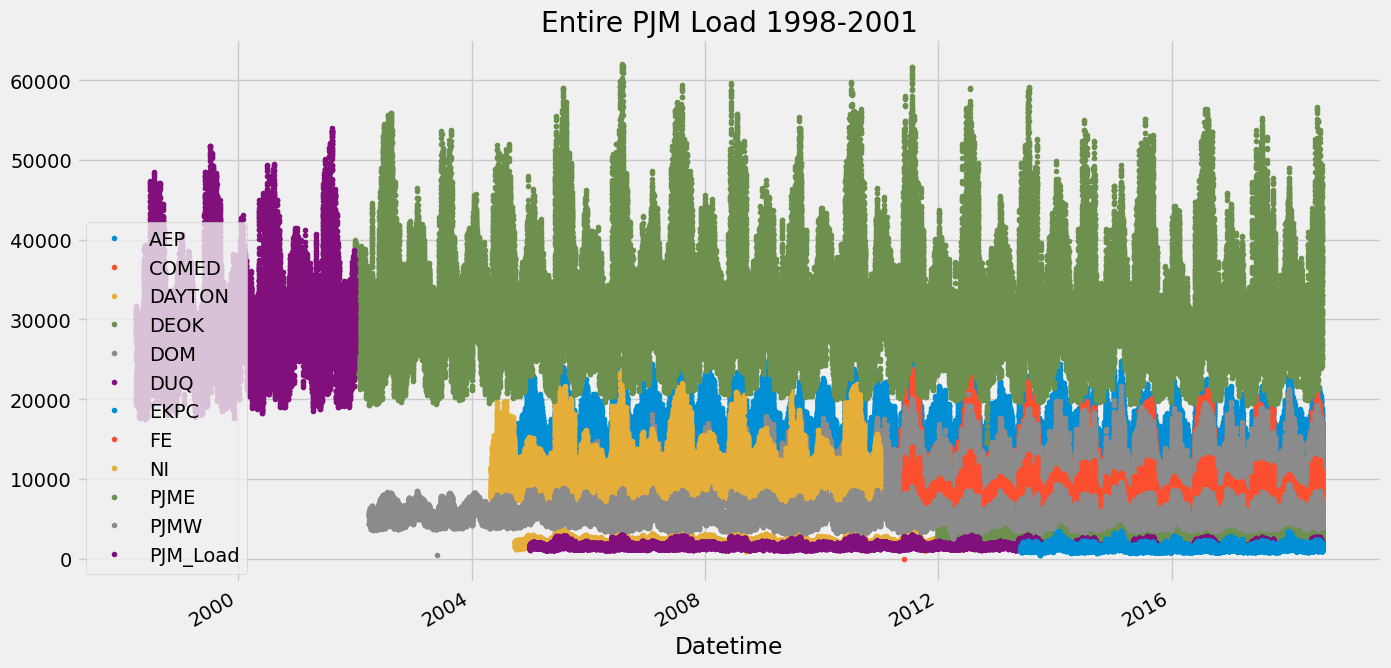

In [712]:
plot = df.plot(style='.', figsize=(15, 8), title='Entire PJM Load 1998-2001')


#### Summer Demand vs Winter Demand

We see dips mid-day in the winter months. Conversely in summer months the daily load is more bell shaped. This is due to high mid-day energy consumtion by air conditioning. In winter months people tend to use less energy mid-day.


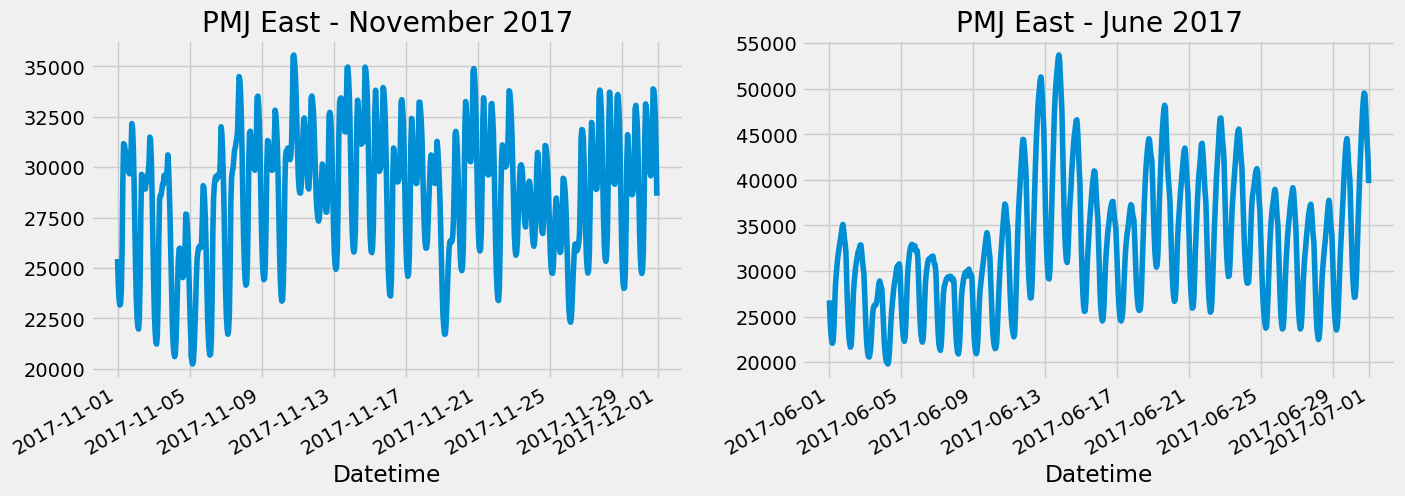

In [713]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the first line on the first axis
df['PJME'].loc[(df['PJME'].index >= '2017-11-01') & (df['PJME'].index < '2017-12-01')].plot(ax=ax1, title='PMJ East - November 2017')

# plot the second line on the second axis
df['PJME'].loc[(df['PJME'].index >= '2017-06-01') & (df['PJME'].index < '2017-07-01')].plot(ax=ax2, title='PMJ East - June 2017')

# show the plot
plt.show()

#### Create timeseries features

In [714]:
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.strftime('%A')
# df['woy'] = df.index.week
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

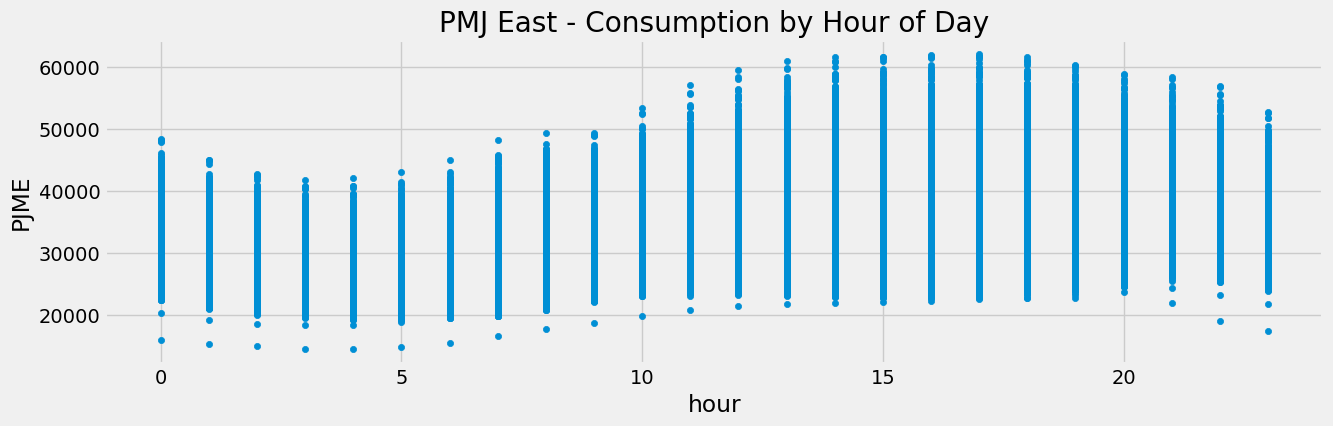

In [715]:
_ = df[['PJME','hour']].plot(x='hour',
                                     y='PJME',
                                     kind='scatter',
                                     figsize=(14,4),
                                     title='PMJ East - Consumption by Hour of Day')

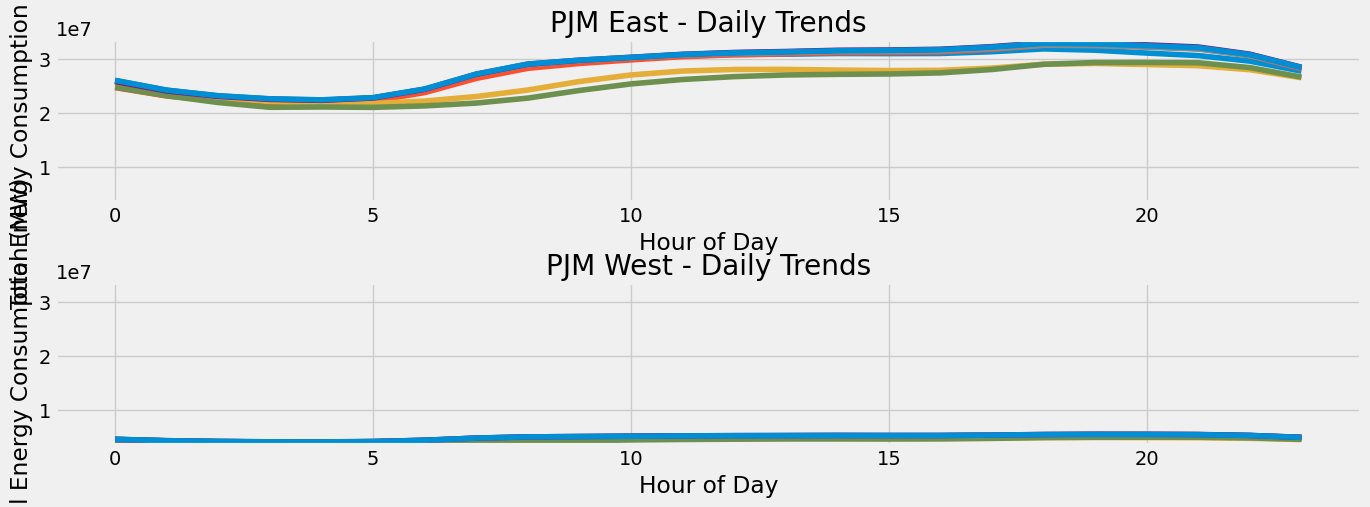

In [716]:
# show PJM East and PMJ West daily trends on the same fig

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))

df.pivot_table(index=df['hour'], 
               columns='weekday', 
               values='PJME',
               aggfunc='sum').plot(ax=ax1,
                                   title='PJM East - Daily Trends',
                                   legend=False)

df.pivot_table(index=df['hour'],
               columns='weekday',
               values='PJMW',
               aggfunc='sum').plot(ax=ax2,
                                   title='PJM West - Daily Trends',
                                   legend=False)

# set y limits to be the same for both plots
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

ax1.set_ylabel('Total Energy Consumption (MW)')
ax2.set_ylabel('Total Energy Consumption (MW)')
ax1.set_xlabel('Hour of Day')
ax2.set_xlabel('Hour of Day')

fig.subplots_adjust(hspace=0.5)

plt.show()


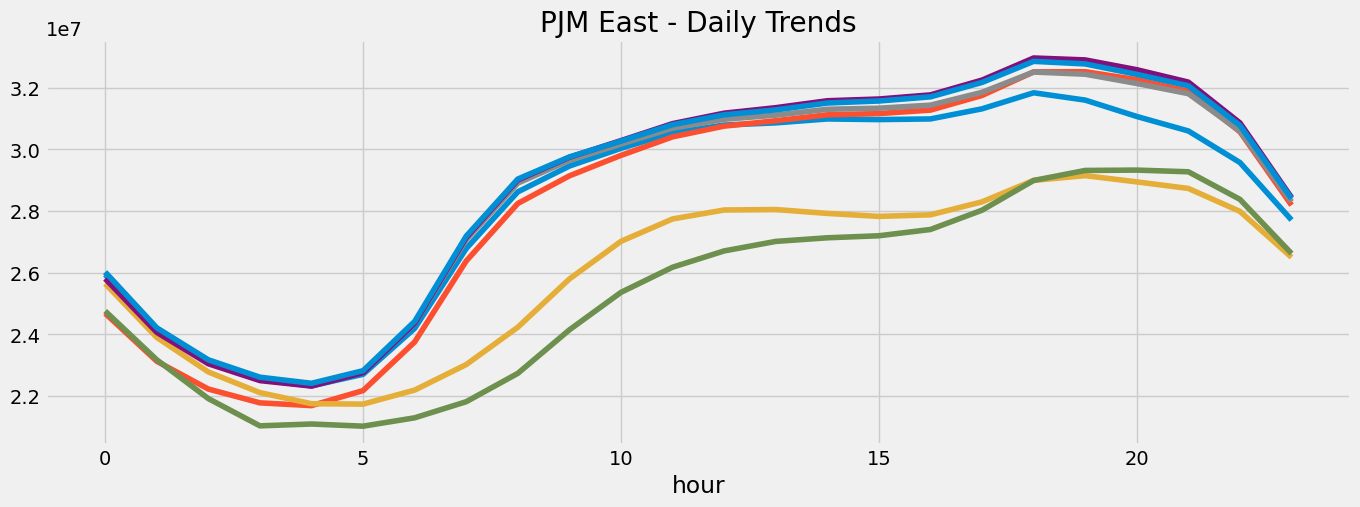

In [717]:
# Looking at just PJM East daily trends
df.pivot_table(index=df['hour'], 
               columns='weekday', 
               values='PJME',
               aggfunc='sum').plot(figsize=(15, 5),
                            title='PJM East - Daily Trends',
                            legend=False)

plt.show()

### Looking at just PJM East for building a regression model

In [718]:
pjm3_df = df[['PJME']].set_index(pd.to_datetime(df.index))
pjm3_df.head()

,PJME
Datetime,
1998-12-31 01:00:00,NaN
1998-12-31 02:00:00,NaN
1998-12-31 03:00:00,NaN
1998-12-31 04:00:00,NaN
1998-12-31 05:00:00,NaN


In [719]:
pjm3_df.isnull().sum()

PJME    32896
dtype: int64

In [720]:
# drop null values
pjm3_df.dropna(inplace=True)

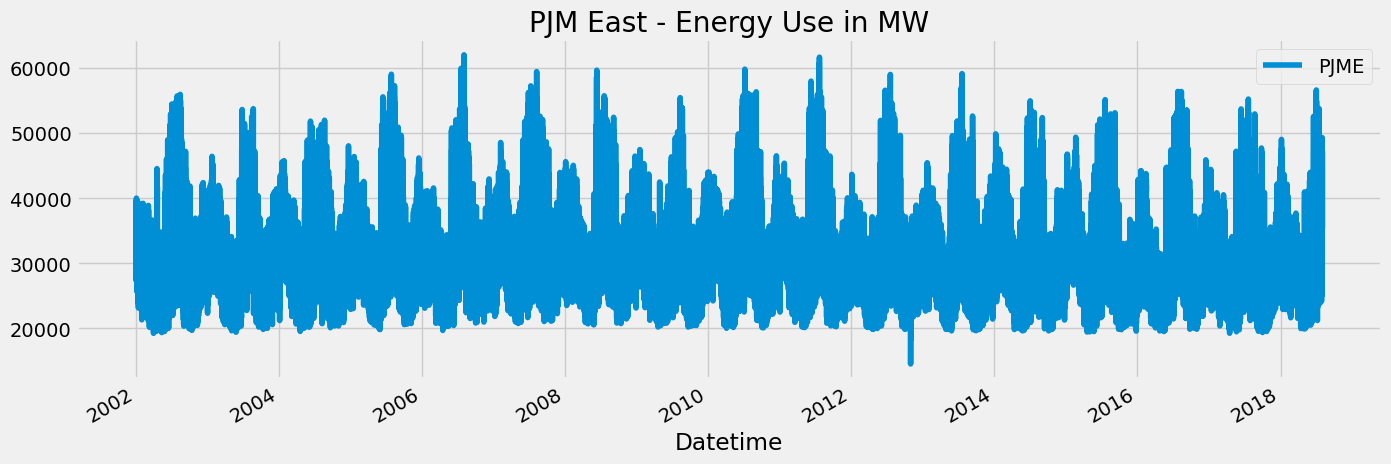

In [721]:
# Visualize the time series data
pjm3_df.plot(figsize=(15, 5), title='PJM East - Energy Use in MW')

plt.show()

### Feature creation

In [722]:
# Function for adding time series features

def create_features(df):
    """
    Creates time series features from datetime index
    """
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df


In [723]:
create_features(pjm3_df)

,PJME,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


Visualize Feature/Target Relationship

In [724]:
# fig, ax = plt.subplots(figsize=(15, 5))
# sns.boxenplot(data=train, x='hour', y='PJME', ax=ax)
# ax.set_title('PJM East - Energy Use by Hour of Day')
# ax.set_ylabel('Energy Consumption (MW)')
# ax.set_xlabel('Hour of Day')

In [725]:
# fig, ax = plt.subplots(figsize=(15, 5))
# sns.boxenplot(data=train, x='month', y='PJME', ax=ax)
# ax.set_title('PJM East - Energy Use by Month')
# ax.set_ylabel('Energy Consumption (MW)')
# ax.set_xlabel('Month')

### Create XGBoost model using our chosen test/train split

In [726]:
# Make sure index is sorted
pjm3_df.sort_index(inplace=True)


In [727]:
# xgBoost model with a train/test split and time series cross-validation 

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME'

# Define the features and target
X = pjm3_df[FEATURES]
y = pjm3_df[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)  

# Initialize the XGBoost model
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model
    reg.fit(X_train_cv, y_train_cv,
        eval_set=[(X_train_cv, y_train_cv), (X_test_cv, y_test_cv)],
        early_stopping_rounds=50,
        verbose=True)
    
    # Make predictions
    y_pred = reg.predict(X_test_cv)
    # Calculate the mean squared error
    mse = mean_squared_error(y_test_cv, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error: {rmse}")

    # Calculate the mean absolute error
    mae = mean_absolute_error(y_test_cv, y_pred)
    print(f"Mean Absolute Error: {mae}")

# Use the holdout set to assess final performance of the model
y_pred_holdout = reg.predict(X_test)
mse_holdout = mean_squared_error(y_test, y_pred_holdout)
print(f"Holdout Mean Squared Error: {mse_holdout}")

# Calculate the root mean squared error of the holdout set
rmse_holdout = np.sqrt(mse_holdout)
print(f"Root Mean Squared Error: {rmse_holdout}")

# Calculate the mean absolute error of the holdout set
mae_holdout = mean_absolute_error(y_test, y_pred_holdout)
print(f"Mean Absolute Error: {mae_holdout}")



[0]	validation_0-rmse:29235.12519	validation_1-rmse:29769.04367
[1]	validation_0-rmse:26349.32519	validation_1-rmse:26910.83157
[2]	validation_0-rmse:23754.41102	validation_1-rmse:24341.47644
[3]	validation_0-rmse:21422.01441	validation_1-rmse:22035.31677
[4]	validation_0-rmse:19325.55233	validation_1-rmse:19962.57966
[5]	validation_0-rmse:17440.33473	validation_1-rmse:18106.91412
[6]	validation_0-rmse:15748.18418	validation_1-rmse:16445.21262
[7]	validation_0-rmse:14227.50207	validation_1-rmse:14956.61772
[8]	validation_0-rmse:12861.41679	validation_1-rmse:13631.25586
[9]	validation_0-rmse:11636.48200	validation_1-rmse:12441.32326
[10]	validation_0-rmse:10541.84107	validation_1-rmse:11372.02361
[11]	validation_0-rmse:9554.46204	validation_1-rmse:10426.56511
[12]	validation_0-rmse:8676.43526	validation_1-rmse:9574.06122
[13]	validation_0-rmse:7891.66789	validation_1-rmse:8813.10512
[14]	validation_0-rmse:7186.59932	validation_1-rmse:8152.59608
[15]	validation_0-rmse:6550.71523	validati

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:5496.56760	validation_1-rmse:6547.01958
[18]	validation_0-rmse:5052.75832	validation_1-rmse:6131.49156
[19]	validation_0-rmse:4666.00616	validation_1-rmse:5769.34461
[20]	validation_0-rmse:4313.69379	validation_1-rmse:5454.01083
[21]	validation_0-rmse:4009.93574	validation_1-rmse:5172.22852
[22]	validation_0-rmse:3751.64494	validation_1-rmse:4933.76800
[23]	validation_0-rmse:3509.95338	validation_1-rmse:4728.77108
[24]	validation_0-rmse:3306.20475	validation_1-rmse:4554.68415
[25]	validation_0-rmse:3122.88764	validation_1-rmse:4419.77242
[26]	validation_0-rmse:2958.00064	validation_1-rmse:4300.21045
[27]	validation_0-rmse:2823.97065	validation_1-rmse:4194.54760
[28]	validation_0-rmse:2710.43432	validation_1-rmse:4096.86800
[29]	validation_0-rmse:2608.00031	validation_1-rmse:4022.42972
[30]	validation_0-rmse:2521.59445	validation_1-rmse:3954.99399
[31]	validation_0-rmse:2446.76330	validation_1-rmse:3885.68836
[32]	validation_0-rmse:2388.02471	validation_1-rmse:383

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:8810.75476	validation_1-rmse:9678.07853
[13]	validation_0-rmse:8029.68236	validation_1-rmse:8864.41170
[14]	validation_0-rmse:7329.74050	validation_1-rmse:8131.80919
[15]	validation_0-rmse:6706.99389	validation_1-rmse:7475.88163
[16]	validation_0-rmse:6154.62871	validation_1-rmse:6924.32386
[17]	validation_0-rmse:5667.51081	validation_1-rmse:6437.71934
[18]	validation_0-rmse:5237.19575	validation_1-rmse:5997.21563
[19]	validation_0-rmse:4848.34818	validation_1-rmse:5607.95375
[20]	validation_0-rmse:4515.84323	validation_1-rmse:5274.55025
[21]	validation_0-rmse:4227.67836	validation_1-rmse:4987.82903
[22]	validation_0-rmse:3964.76390	validation_1-rmse:4700.05275
[23]	validation_0-rmse:3746.99581	validation_1-rmse:4490.63756
[24]	validation_0-rmse:3555.39987	validation_1-rmse:4300.93818
[25]	validation_0-rmse:3382.66466	validation_1-rmse:4142.13456
[26]	validation_0-rmse:3241.13272	validation_1-rmse:4016.73290
[27]	validation_0-rmse:3114.31460	validation_1-rmse:390

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:13232.51781	validation_1-rmse:12961.62418
[9]	validation_0-rmse:11989.73864	validation_1-rmse:11720.58253
[10]	validation_0-rmse:10877.08860	validation_1-rmse:10610.80098
[11]	validation_0-rmse:9880.82479	validation_1-rmse:9582.80994
[12]	validation_0-rmse:8993.56188	validation_1-rmse:8683.58729
[13]	validation_0-rmse:8201.95057	validation_1-rmse:7877.72985
[14]	validation_0-rmse:7497.66033	validation_1-rmse:7185.68138
[15]	validation_0-rmse:6873.19823	validation_1-rmse:6550.32787
[16]	validation_0-rmse:6319.02400	validation_1-rmse:6012.21972
[17]	validation_0-rmse:5827.95652	validation_1-rmse:5510.96548
[18]	validation_0-rmse:5399.25811	validation_1-rmse:5113.91077
[19]	validation_0-rmse:5022.08722	validation_1-rmse:4769.45163
[20]	validation_0-rmse:4688.63445	validation_1-rmse:4467.62776
[21]	validation_0-rmse:4402.52635	validation_1-rmse:4224.16222
[22]	validation_0-rmse:4151.05423	validation_1-rmse:4025.78642
[23]	validation_0-rmse:3931.90197	validation_1-rmse

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:14600.24603	validation_1-rmse:14004.18657
[8]	validation_0-rmse:13217.95261	validation_1-rmse:12624.08320
[9]	validation_0-rmse:11978.62423	validation_1-rmse:11386.77767
[10]	validation_0-rmse:10870.22956	validation_1-rmse:10276.85529
[11]	validation_0-rmse:9880.03390	validation_1-rmse:9281.10139
[12]	validation_0-rmse:8995.66654	validation_1-rmse:8403.69918
[13]	validation_0-rmse:8209.15232	validation_1-rmse:7635.91983
[14]	validation_0-rmse:7510.45408	validation_1-rmse:6944.77286
[15]	validation_0-rmse:6890.45032	validation_1-rmse:6343.79869
[16]	validation_0-rmse:6342.44600	validation_1-rmse:5809.49372
[17]	validation_0-rmse:5860.44935	validation_1-rmse:5349.27508
[18]	validation_0-rmse:5431.78017	validation_1-rmse:4933.56208
[19]	validation_0-rmse:5062.79263	validation_1-rmse:4600.12961
[20]	validation_0-rmse:4736.34575	validation_1-rmse:4311.11815
[21]	validation_0-rmse:4457.41641	validation_1-rmse:4064.95125
[22]	validation_0-rmse:4208.07900	validation_1-rms

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:17804.78479	validation_1-rmse:17448.48503
[6]	validation_0-rmse:16089.62075	validation_1-rmse:15768.50088
[7]	validation_0-rmse:14550.63893	validation_1-rmse:14247.11332
[8]	validation_0-rmse:13173.57125	validation_1-rmse:12910.70950
[9]	validation_0-rmse:11938.77766	validation_1-rmse:11734.11902
[10]	validation_0-rmse:10835.44368	validation_1-rmse:10689.11267
[11]	validation_0-rmse:9849.20047	validation_1-rmse:9734.63552
[12]	validation_0-rmse:8970.71715	validation_1-rmse:8910.82157
[13]	validation_0-rmse:8185.52021	validation_1-rmse:8176.16633
[14]	validation_0-rmse:7490.15587	validation_1-rmse:7522.49967
[15]	validation_0-rmse:6872.06279	validation_1-rmse:6967.32939
[16]	validation_0-rmse:6327.19348	validation_1-rmse:6499.16631
[17]	validation_0-rmse:5842.90370	validation_1-rmse:6075.57550
[18]	validation_0-rmse:5422.58779	validation_1-rmse:5708.98968
[19]	validation_0-rmse:5052.82717	validation_1-rmse:5391.81362
[20]	validation_0-rmse:4726.16786	validation_1-r

In [728]:
# Make predictions on the test set
y_pred = reg.predict(X_test)

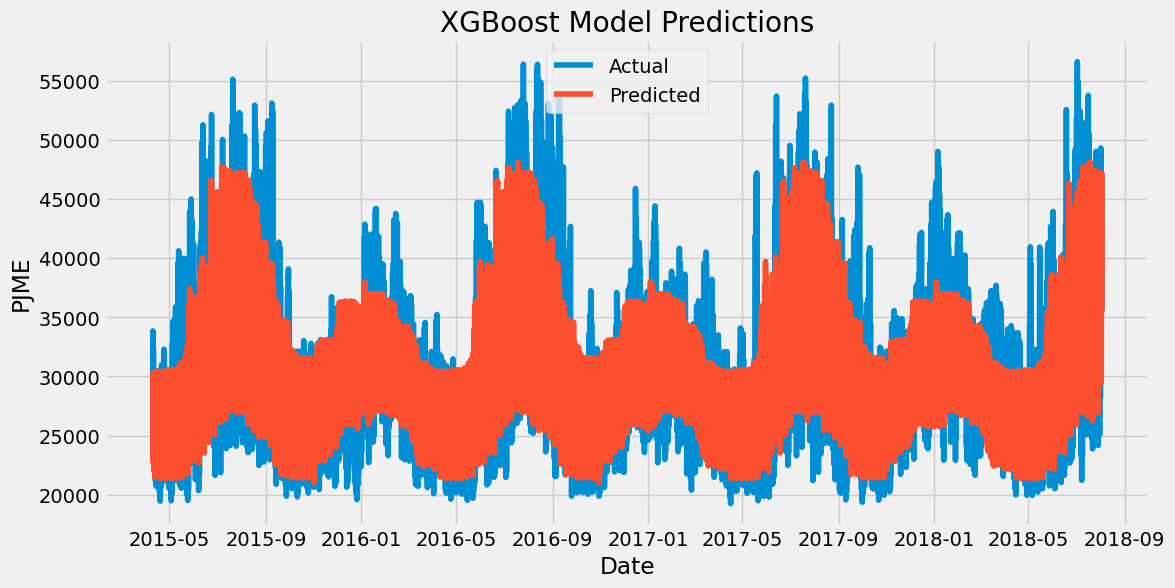

In [729]:
# Plot the actual values and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions')
plt.legend()
plt.show()

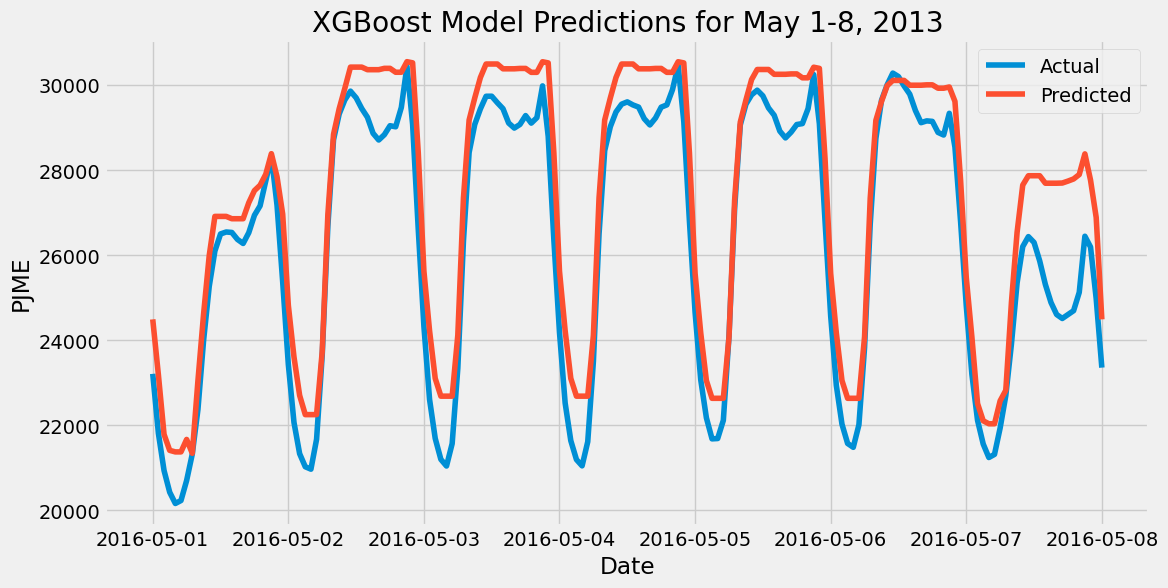

In [730]:
# Looking at one week of data
# Looking at one week of data
# Select the data for one week in May 2016
start_date = '2016-05-01'
end_date = '2016-05-08'
mask = (y_test.index >= start_date) & (y_test.index <= end_date)
y_test_week = y_test.loc[mask]
y_pred_week = pd.Series(y_pred, index=y_test.index).loc[mask]

# Plot the actual values and predicted values for one week
plt.figure(figsize=(12, 6))
plt.plot(y_test_week.index, y_test_week.values, label='Actual')
plt.plot(y_test_week.index, y_pred_week, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions for May 1-8, 2013')
plt.legend()
plt.show()


##### Feature importance of model # 1

In [731]:
fi = pd.DataFrame(data=reg.feature_importances_,
                index =reg.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=True)

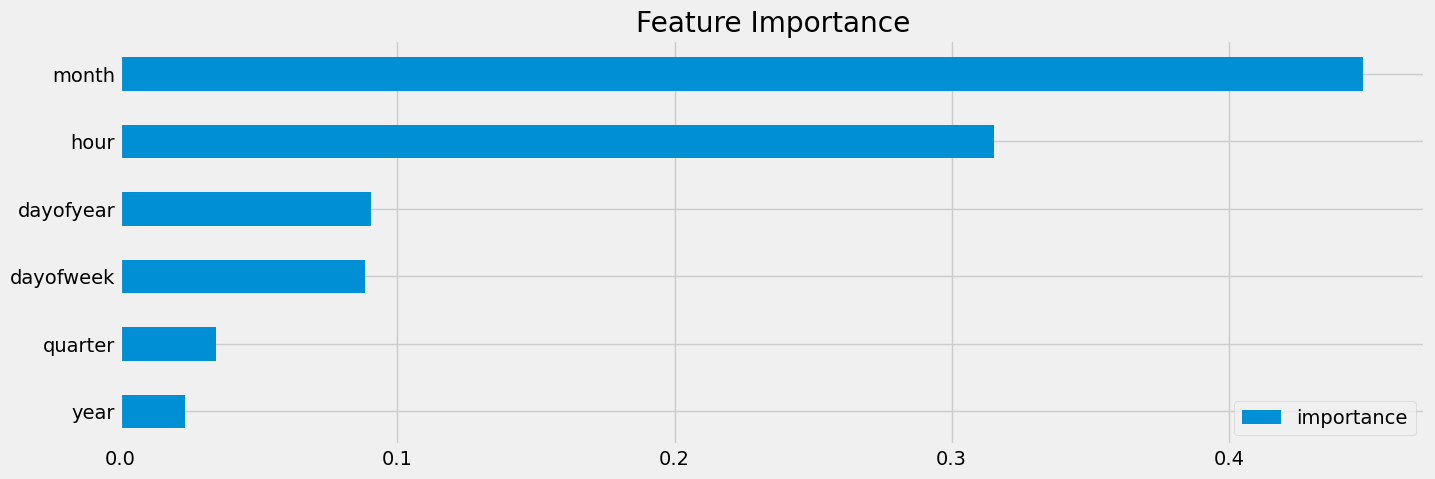

In [732]:
fi.plot(kind='barh', figsize=(15, 5), title='Feature Importance')
plt.show()

### Add holiday features for reg # 2

In [733]:
#API call to get the holidays

# Set the start and end years
start_year = 2002
end_year = 2023

# Initialize an empty list to store the holiday data
holidays = []

# Loop through the years and make an API call for each year
for year in range(start_year, end_year + 1):
    url = f'https://date.nager.at/api/v3/PublicHolidays/{year}/US'
    response = requests.get(url)
    if response.status_code == 200:
        year_holidays = response.json()
        holidays.extend(year_holidays)
    else:
        print(f'Error fetching holidays for {year}')

# Convert the holiday data to a Pandas DataFrame
df_holidays = pd.DataFrame(holidays)

# Filter the DataFrame to include only holidays from January 1, 2015
df_holidays = df_holidays[df_holidays['date'] >= '2002-12-31']

In [734]:
df_holidays['date'] = pd.to_datetime(df_holidays['date']).dt.date

In [735]:
df_holidays.head()

,date,localName,name,countryCode,fixed,global,counties,launchYear,types
12,2003-01-01,New Year's Day,New Year's Day,US,False,True,None,NaN,[Public]
13,2003-01-20,"Martin Luther King, Jr. Day","Martin Luther King, Jr. Day",US,False,True,None,NaN,[Public]
14,2003-02-17,Presidents Day,Washington's Birthday,US,False,True,None,NaN,[Public]
15,2003-04-18,Good Friday,Good Friday,US,False,False,"[US-CT, US-DE, US-HI, US-IN, US-KY, US-LA, US-...",NaN,[Public]
16,2003-04-18,Good Friday,Good Friday,US,False,False,[US-TX],NaN,[Optional]


In [736]:
df_holidays.dtypes

date            object
localName       object
name            object
countryCode     object
fixed             bool
global            bool
counties        object
launchYear     float64
types           object
dtype: object

In [737]:
df_holidays.set_index('date', inplace=True)

In [738]:
pjm3_df.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1


In [739]:
# Check for duplicate indices that would cause problems with the merge
print(pjm3_df.index.duplicated().any())
print(df_holidays.index.duplicated().any())

True
True


In [740]:
# selects all the values that are not duplicated. By indexing  with this mask
# I am keeping only the rows with unique index values
# pjm3_df = pjm3_df[~pjm3_df.index.duplicated()]
df_holidays = df_holidays[~df_holidays.index.duplicated()]


In [741]:
# merge holiday info with PJME data on date, while preserving the datetime index
pjm3_df2 = pjm3_df.merge(df_holidays[['localName']], how='left', left_index=True, right_index=True)


In [742]:
pjm3_df.index.equals(pjm3_df2.index)

True

In [743]:
pjm3_df2.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear,localName
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN


In [744]:
pjm3_df2['localName'].value_counts()

localName
New Year's Day                 16
Martin Luther King, Jr. Day    16
Presidents Day                 16
Good Friday                    16
Memorial Day                   16
Independence Day               16
Labor Day                      15
Columbus Day                   15
Veterans Day                   15
Thanksgiving Day               15
Christmas Day                  15
Name: count, dtype: int64

In [745]:
# One-hot encode the 'localName' column
pjm3_df2 = pd.concat([pjm3_df2, pd.get_dummies(pjm3_df2['localName'], prefix='holiday')], axis=1)

# Drop the original 'localName' column
pjm3_df2.drop('localName', axis=1, inplace=True)


### Running model #2 with holiday data


In [746]:
pjm3_df2.columns

Index(['PJME', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'holiday_Christmas Day', 'holiday_Columbus Day', 'holiday_Good Friday',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King, Jr. Day', 'holiday_Memorial Day',
       'holiday_New Year's Day', 'holiday_Presidents Day',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day'],
      dtype='object')

In [747]:
# Model #2 uses times series the same xgb model and cross-validation

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'holiday_Christmas Day', 'holiday_Columbus Day',
            'holiday_Good Friday', 'holiday_Independence Day', 'holiday_Labor Day',
            'holiday_Martin Luther King, Jr. Day', 'holiday_Memorial Day',
            "holiday_New Year's Day", 'holiday_Presidents Day',
            'holiday_Thanksgiving Day', 'holiday_Veterans Day']
TARGET = 'PJME'

# Assuming your data is in a DataFrame called data
X2 = pjm3_df2[FEATURES]
y2 = pjm3_df2[TARGET]


# Split the data into training and testing sets
X_train_all2, X_test_all2, y_train_all2, y_test_all2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)

# Create a TimeSeriesSplit object
tscv2 = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits according to dataset size

# Initialize the XGBoost model
reg2 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

# Perform Time Series Cross-Validation
for train_index2, test_index2 in tscv2.split(X_train_all2):
    X_train2, X_test2 = X_train_all2.iloc[train_index2], X_train_all2.iloc[test_index2]
    y_train2, y_test2 = y_train_all2.iloc[train_index2], y_train_all2.iloc[test_index2]

    reg2.fit(X_train2, y_train2,
             eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
             early_stopping_rounds=50,
             verbose=True)

    y_pred_cv2 = reg2.predict(X_test2)
    mse_cv2 = mean_squared_error(y_test2, y_pred_cv2)
    print(f"Mean Squared Error (CV): {mse_cv2}")
    # Calculate the root mean squared error
    rmse2 = np.sqrt(mse_cv2)
    print(f"Root Mean Squared Error: {rmse2}")

    # Calculate the mean absolute error
    mae2 = mean_absolute_error(y_test2, y_pred_cv2)
    print(f"Mean Absolute Error: {mae2}")

# Use the holdout set to assess final performance of the model
y_pred_holdout2 = reg2.predict(X_test_all2)  # Use X_test_all2 instead of X_test2
mse_holdout2 = mean_squared_error(y_test_all2, y_pred_holdout2)  # Use y_test_all2 instead of y_test2
print(f"Holdout Mean Squared Error: {mse_holdout2}")

# Calculate the root mean squared error of the holdout set
rmse_holdout2 = np.sqrt(mse_holdout2)
print(f"Root Mean Squared Error: {rmse_holdout2}")

# Calculate the mean absolute error of the holdout set
mae_holdout2 = mean_absolute_error(y_test_all2, y_pred_holdout2)  # Use y_test_all2 instead of y_test2
print(f"Mean Absolute Error: {mae_holdout2}")


[0]	validation_0-rmse:29235.12519	validation_1-rmse:29769.04367
[1]	validation_0-rmse:26349.32519	validation_1-rmse:26910.83157
[2]	validation_0-rmse:23754.41102	validation_1-rmse:24341.47644
[3]	validation_0-rmse:21422.01441	validation_1-rmse:22035.31677
[4]	validation_0-rmse:19325.55233	validation_1-rmse:19962.57966
[5]	validation_0-rmse:17440.33473	validation_1-rmse:18106.91412
[6]	validation_0-rmse:15748.18418	validation_1-rmse:16445.21262
[7]	validation_0-rmse:14227.50207	validation_1-rmse:14956.61772
[8]	validation_0-rmse:12861.41679	validation_1-rmse:13631.25586
[9]	validation_0-rmse:11636.48200	validation_1-rmse:12441.32326
[10]	validation_0-rmse:10541.84107	validation_1-rmse:11372.02361
[11]	validation_0-rmse:9554.46204	validation_1-rmse:10426.56511
[12]	validation_0-rmse:8676.43526	validation_1-rmse:9574.06122


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:7891.66789	validation_1-rmse:8813.10512
[14]	validation_0-rmse:7186.59932	validation_1-rmse:8152.59608
[15]	validation_0-rmse:6550.71523	validation_1-rmse:7536.11938
[16]	validation_0-rmse:5996.19651	validation_1-rmse:7003.81819
[17]	validation_0-rmse:5496.56760	validation_1-rmse:6547.01958
[18]	validation_0-rmse:5052.75832	validation_1-rmse:6131.49156
[19]	validation_0-rmse:4666.00616	validation_1-rmse:5769.34461
[20]	validation_0-rmse:4313.69379	validation_1-rmse:5454.01083
[21]	validation_0-rmse:4009.93574	validation_1-rmse:5172.22852
[22]	validation_0-rmse:3751.64494	validation_1-rmse:4933.76800
[23]	validation_0-rmse:3509.95338	validation_1-rmse:4728.77108
[24]	validation_0-rmse:3306.20475	validation_1-rmse:4554.68415
[25]	validation_0-rmse:3122.88764	validation_1-rmse:4419.77242
[26]	validation_0-rmse:2958.00064	validation_1-rmse:4300.21045
[27]	validation_0-rmse:2823.97065	validation_1-rmse:4194.54760
[28]	validation_0-rmse:2710.43432	validation_1-rmse:409

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:11773.28019	validation_1-rmse:12739.13976
[10]	validation_0-rmse:10673.57105	validation_1-rmse:11593.23461
[11]	validation_0-rmse:9687.87007	validation_1-rmse:10564.89010
[12]	validation_0-rmse:8810.75476	validation_1-rmse:9678.07853
[13]	validation_0-rmse:8029.68236	validation_1-rmse:8864.41170
[14]	validation_0-rmse:7329.74050	validation_1-rmse:8131.80919
[15]	validation_0-rmse:6706.99389	validation_1-rmse:7475.88163
[16]	validation_0-rmse:6154.62871	validation_1-rmse:6924.32386
[17]	validation_0-rmse:5667.51081	validation_1-rmse:6437.71934
[18]	validation_0-rmse:5237.19575	validation_1-rmse:5997.21563
[19]	validation_0-rmse:4848.34818	validation_1-rmse:5607.95375
[20]	validation_0-rmse:4515.84323	validation_1-rmse:5274.55025
[21]	validation_0-rmse:4227.67836	validation_1-rmse:4987.82903
[22]	validation_0-rmse:3964.76390	validation_1-rmse:4700.05275
[23]	validation_0-rmse:3746.99581	validation_1-rmse:4490.63756
[24]	validation_0-rmse:3555.39987	validation_1-rmse

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:14619.66290	validation_1-rmse:14353.06150
[8]	validation_0-rmse:13232.51781	validation_1-rmse:12961.62418
[9]	validation_0-rmse:11989.73864	validation_1-rmse:11720.58253
[10]	validation_0-rmse:10877.08860	validation_1-rmse:10610.80098
[11]	validation_0-rmse:9880.82479	validation_1-rmse:9582.80994
[12]	validation_0-rmse:8993.56188	validation_1-rmse:8683.58729
[13]	validation_0-rmse:8201.95057	validation_1-rmse:7877.72985
[14]	validation_0-rmse:7497.66033	validation_1-rmse:7185.68138
[15]	validation_0-rmse:6873.19823	validation_1-rmse:6550.32787
[16]	validation_0-rmse:6319.02400	validation_1-rmse:6012.21972
[17]	validation_0-rmse:5827.95652	validation_1-rmse:5510.96548
[18]	validation_0-rmse:5399.25811	validation_1-rmse:5113.91077
[19]	validation_0-rmse:5022.08722	validation_1-rmse:4769.45163
[20]	validation_0-rmse:4688.63445	validation_1-rmse:4467.62776
[21]	validation_0-rmse:4402.52635	validation_1-rmse:4224.16222
[22]	validation_0-rmse:4151.05423	validation_1-rms

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:17865.32186	validation_1-rmse:17270.23726
[6]	validation_0-rmse:16144.47798	validation_1-rmse:15547.41535
[7]	validation_0-rmse:14600.24603	validation_1-rmse:14004.18657
[8]	validation_0-rmse:13217.95261	validation_1-rmse:12624.08320
[9]	validation_0-rmse:11978.62423	validation_1-rmse:11386.77767
[10]	validation_0-rmse:10870.22956	validation_1-rmse:10276.85529
[11]	validation_0-rmse:9880.03390	validation_1-rmse:9281.10139
[12]	validation_0-rmse:8995.66654	validation_1-rmse:8403.69918
[13]	validation_0-rmse:8209.15232	validation_1-rmse:7635.91983
[14]	validation_0-rmse:7510.45408	validation_1-rmse:6944.77286
[15]	validation_0-rmse:6890.45032	validation_1-rmse:6343.79869
[16]	validation_0-rmse:6342.44600	validation_1-rmse:5809.49372
[17]	validation_0-rmse:5860.44935	validation_1-rmse:5349.27508
[18]	validation_0-rmse:5431.78017	validation_1-rmse:4933.56208
[19]	validation_0-rmse:5062.79263	validation_1-rmse:4600.12961
[20]	validation_0-rmse:4736.34575	validation_1-r

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:17804.78479	validation_1-rmse:17448.48503
[6]	validation_0-rmse:16089.62075	validation_1-rmse:15768.50088
[7]	validation_0-rmse:14550.63893	validation_1-rmse:14247.11332
[8]	validation_0-rmse:13173.57125	validation_1-rmse:12910.70950
[9]	validation_0-rmse:11938.77766	validation_1-rmse:11734.11902
[10]	validation_0-rmse:10835.44368	validation_1-rmse:10689.11267
[11]	validation_0-rmse:9849.20047	validation_1-rmse:9734.63552
[12]	validation_0-rmse:8970.71715	validation_1-rmse:8910.82157
[13]	validation_0-rmse:8185.52021	validation_1-rmse:8176.16633
[14]	validation_0-rmse:7490.15587	validation_1-rmse:7522.49967
[15]	validation_0-rmse:6872.06279	validation_1-rmse:6967.32939
[16]	validation_0-rmse:6327.19348	validation_1-rmse:6499.16631
[17]	validation_0-rmse:5842.90370	validation_1-rmse:6075.57550
[18]	validation_0-rmse:5422.58779	validation_1-rmse:5708.98968
[19]	validation_0-rmse:5052.82717	validation_1-rmse:5391.81362
[20]	validation_0-rmse:4726.16786	validation_1-r

In [748]:
# Make predictions on the test set
y_pred2 = reg2.predict(X_test2)

### feature importance of second set

In [749]:
fi2 = pd.DataFrame(data=reg2.feature_importances_,
                index =reg2.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=False)

fi2

,importance
month,0.450739
hour,0.313244
dayofyear,0.089524
dayofweek,0.088619
quarter,0.034228
year,0.023075
holiday_Memorial Day,0.000314
holiday_Christmas Day,0.000217
holiday_New Year's Day,0.000039
holiday_Thanksgiving Day,0.000000


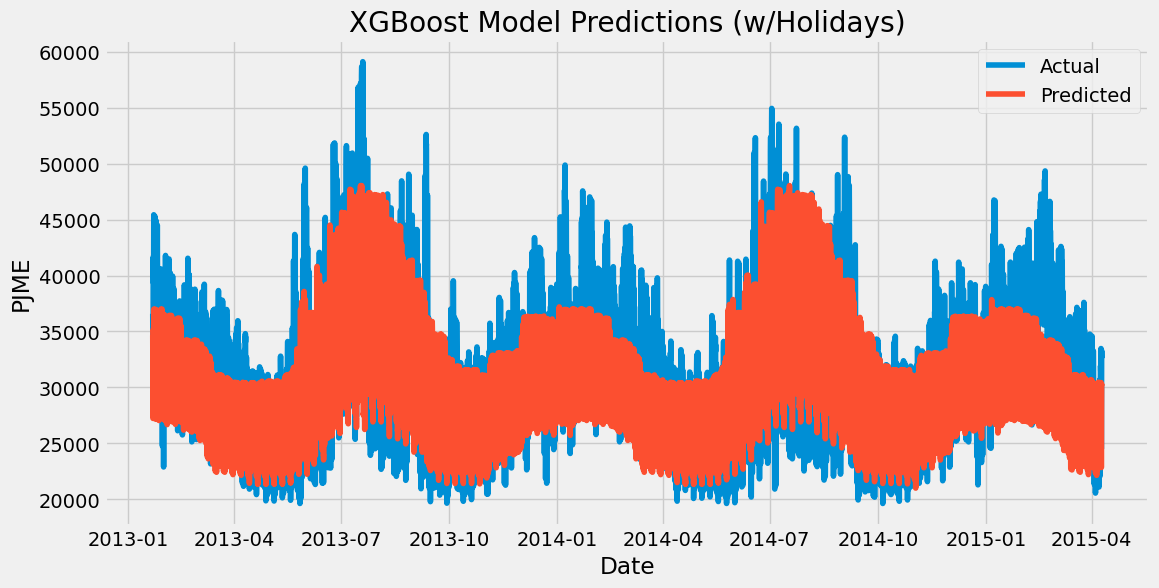

In [750]:
# Plot the actual values and predicted values for the second model
plt.figure(figsize=(12, 6))
plt.plot(y_test2.index, y_test2.values, label='Actual')
plt.plot(y_test2.index, y_pred2, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions (w/Holidays)')
plt.legend()
plt.show()


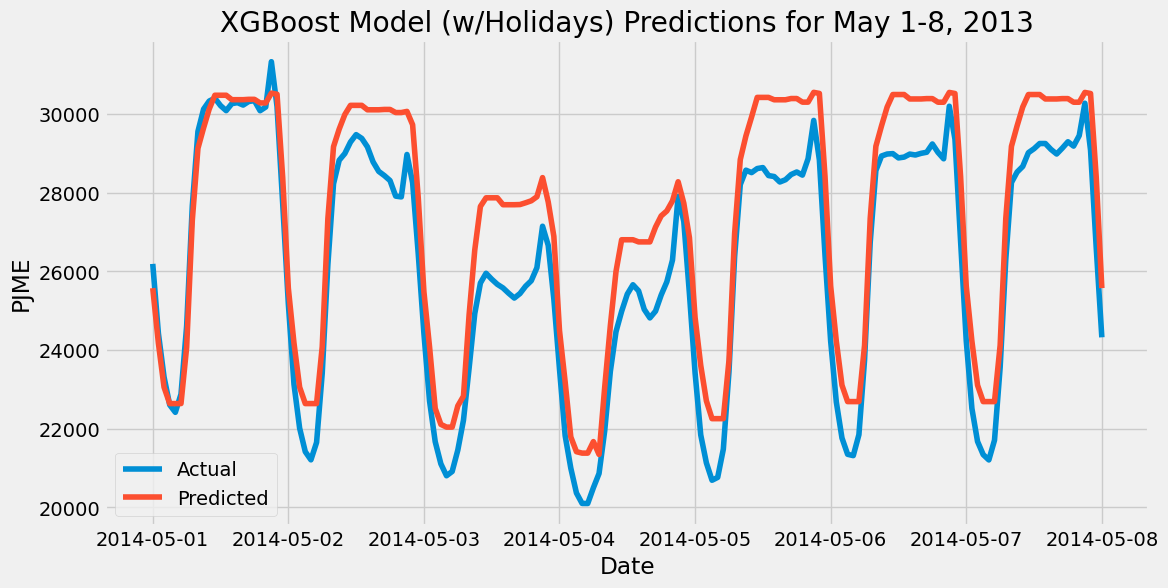

In [751]:
# Looking at one week of data
# Select the data for one week in May 2014
start_date = '2014-05-01'
end_date = '2014-05-08'
mask = (y_test2.index >= start_date) & (y_test2.index <= end_date)
y_test_week2 = y_test2.loc[mask]
y_pred_week2 = pd.Series(y_pred2, index=y_test2.index).loc[mask]

# Plot the actual values and predicted values for one week
plt.figure(figsize=(12, 6))
plt.plot(y_test_week2.index, y_test_week2.values, label='Actual')
plt.plot(y_test_week2.index, y_pred_week2, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model (w/Holidays) Predictions for May 1-8, 2013')
plt.legend()
plt.show()


### Add lag features - Run # 3

In [752]:
pjm3_df3 = pjm3_df2.copy()

In [753]:
pjm3_df3.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear,holiday_Christmas Day,holiday_Columbus Day,holiday_Good Friday,holiday_Independence Day,holiday_Labor Day,"holiday_Martin Luther King, Jr. Day",holiday_Memorial Day,holiday_New Year's Day,holiday_Presidents Day,holiday_Thanksgiving Day,holiday_Veterans Day
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,False,False,False,False,False,False,False,False,False,False,False


In [754]:
# Set lags on the training data
pjm3_df3['lag_1h'] = pjm3_df3['PJME'].shift(1)
pjm3_df3['lag_2h'] = pjm3_df3['PJME'].shift(2)
pjm3_df3['lag_3h'] = pjm3_df3['PJME'].shift(3)

# Daily lag
pjm3_df3['lag_1d'] = pjm3_df3['PJME'].shift(24)

# Weekly lag
pjm3_df3['lag_1w'] = pjm3_df3['PJME'].shift(168)

# Set lags on the test set
pjm3_df3['lag_1h'] = pjm3_df3['PJME'].shift(1)
pjm3_df3['lag_2h'] = pjm3_df3['PJME'].shift(2)
pjm3_df3['lag_3h'] = pjm3_df3['PJME'].shift(3)

# Daily lag
pjm3_df3['lag_1d'] = pjm3_df3['PJME'].shift(24)

# Weekly lag
pjm3_df3['lag_1w'] = pjm3_df3['PJME'].shift(168)

In [755]:
pjm3_df3.columns

Index(['PJME', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'holiday_Christmas Day', 'holiday_Columbus Day', 'holiday_Good Friday',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King, Jr. Day', 'holiday_Memorial Day',
       'holiday_New Year's Day', 'holiday_Presidents Day',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day', 'lag_1h', 'lag_2h',
       'lag_3h', 'lag_1d', 'lag_1w'],
      dtype='object')

In [756]:
# regression # 3 using lags
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag_1h', 'lag_2h','lag_3h', 'lag_1d', 'lag_1w']
TARGET = ['PJME']

# Assuming your data is in a DataFrame called pjm3_df3
X3 = pjm3_df3[FEATURES]
y3 = pjm3_df3[TARGET]

# Split the data into training and testing sets
X_train_all3, X_test_all3, y_train_all3, y_test_all3 = train_test_split(X3, y3, test_size=0.2, shuffle=False)

# Create a TimeSeriesSplit object
tscv3 = TimeSeriesSplit(n_splits=5)  

# Initialize the XGBoost model
reg3 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

# Perform Time Series Cross-Validation
for train_index3, test_index3 in tscv.split(X_train_all3):
    X_train3, X_test3 = X_train_all3.iloc[train_index3], X_train_all3.iloc[test_index3]
    y_train3, y_test3 = y_train_all3.iloc[train_index3], y_train_all3.iloc[test_index3]

    reg3.fit(X_train3, y_train3,
             eval_set=[(X_train3, y_train3), (X_test3, y_test3)],
             early_stopping_rounds=50, 
             verbose=True)

    y_pred_cv3 = reg3.predict(X_test3)
    mse_cv3 = mean_squared_error(y_test3, y_pred_cv3)
    print(f"Mean Squared Error (CV): {mse_cv3}")

    # Calculate the root mean squared error
    rmse3 = np.sqrt(mse_cv3)
    print(f"Root Mean Squared Error: {rmse3}")

    # Calculate the mean absolute error
    mae3 = mean_absolute_error(y_test3, y_pred_cv3)
    print(f"Mean Absolute Error: {mae3}")

# Use the holdout set to assess final performance of the model
y_pred_holdout3 = reg3.predict(X_test_all3)  # Use X_test_all3 instead of X_test3
mse_holdout3 = mean_squared_error(y_test_all3, y_pred_holdout3)  # Use y_test_all3 instead of y_test3
print(f"Holdout Mean Squared Error: {mse_holdout3}")

# Calculate the root mean squared error of the holdout set
rmse_holdout3 = np.sqrt(mse_holdout3)
print(f"Root Mean Squared Error: {rmse_holdout3}")

# Calculate the mean absolute error of the holdout set
mae_holdout3 = mean_absolute_error(y_test_all3, y_pred_holdout3)  # Use y_test_all3 instead of y_test3
print(f"Mean Absolute Error: {mae_holdout3}")




[0]	validation_0-rmse:29209.14720	validation_1-rmse:29668.27704
[1]	validation_0-rmse:26297.61209	validation_1-rmse:26714.85536
[2]	validation_0-rmse:23677.17846	validation_1-rmse:24055.88076
[3]	validation_0-rmse:21318.64064	validation_1-rmse:21662.53632
[4]	validation_0-rmse:19195.76174	validation_1-rmse:19509.38646
[5]	validation_0-rmse:17285.08989	validation_1-rmse:17571.97856
[6]	validation_0-rmse:15565.51658	validation_1-rmse:15827.96995
[7]	validation_0-rmse:14017.68814	validation_1-rmse:14256.22231
[8]	validation_0-rmse:12624.53261	validation_1-rmse:12843.15174
[9]	validation_0-rmse:11370.55297	validation_1-rmse:11569.72735
[10]	validation_0-rmse:10242.08677	validation_1-rmse:10425.18888


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:9226.44187	validation_1-rmse:9393.60156
[12]	validation_0-rmse:8312.59851	validation_1-rmse:8467.26971
[13]	validation_0-rmse:7490.13506	validation_1-rmse:7632.30154
[14]	validation_0-rmse:6750.01915	validation_1-rmse:6880.36390
[15]	validation_0-rmse:6084.46305	validation_1-rmse:6204.79923
[16]	validation_0-rmse:5485.54151	validation_1-rmse:5596.18270
[17]	validation_0-rmse:4946.90145	validation_1-rmse:5050.45775
[18]	validation_0-rmse:4462.48566	validation_1-rmse:4558.69685
[19]	validation_0-rmse:4027.20267	validation_1-rmse:4116.87585
[20]	validation_0-rmse:3635.75258	validation_1-rmse:3719.61435
[21]	validation_0-rmse:3283.98477	validation_1-rmse:3362.82762
[22]	validation_0-rmse:2967.51496	validation_1-rmse:3041.46961
[23]	validation_0-rmse:2683.98325	validation_1-rmse:2755.03838
[24]	validation_0-rmse:2429.15395	validation_1-rmse:2496.93217
[25]	validation_0-rmse:2200.71603	validation_1-rmse:2265.44044
[26]	validation_0-rmse:1996.36043	validation_1-rmse:205

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:15675.86435	validation_1-rmse:16480.10795
[7]	validation_0-rmse:14115.21902	validation_1-rmse:14847.97679
[8]	validation_0-rmse:12710.45617	validation_1-rmse:13378.79126
[9]	validation_0-rmse:11446.29430	validation_1-rmse:12058.18761
[10]	validation_0-rmse:10308.54777	validation_1-rmse:10868.79908
[11]	validation_0-rmse:9284.61989	validation_1-rmse:9798.14840
[12]	validation_0-rmse:8363.19037	validation_1-rmse:8833.88601
[13]	validation_0-rmse:7534.00163	validation_1-rmse:7965.19910
[14]	validation_0-rmse:6788.13053	validation_1-rmse:7183.15219
[15]	validation_0-rmse:6116.89497	validation_1-rmse:6480.35649
[16]	validation_0-rmse:5513.28133	validation_1-rmse:5846.98058
[17]	validation_0-rmse:4970.27948	validation_1-rmse:5278.00394
[18]	validation_0-rmse:4482.10898	validation_1-rmse:4766.34061
[19]	validation_0-rmse:4043.39438	validation_1-rmse:4305.90704
[20]	validation_0-rmse:3649.29531	validation_1-rmse:3893.92230
[21]	validation_0-rmse:3295.06864	validation_1-rm

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:19648.09352	validation_1-rmse:19498.23595
[5]	validation_0-rmse:17689.31576	validation_1-rmse:17551.93854
[6]	validation_0-rmse:15926.65595	validation_1-rmse:15801.46106
[7]	validation_0-rmse:14340.24595	validation_1-rmse:14225.34014
[8]	validation_0-rmse:12912.67394	validation_1-rmse:12807.63915
[9]	validation_0-rmse:11627.84147	validation_1-rmse:11532.07955
[10]	validation_0-rmse:10471.52833	validation_1-rmse:10383.32329
[11]	validation_0-rmse:9430.98037	validation_1-rmse:9350.71692
[12]	validation_0-rmse:8494.80499	validation_1-rmse:8420.84892
[13]	validation_0-rmse:7652.13290	validation_1-rmse:7584.56468
[14]	validation_0-rmse:6894.03659	validation_1-rmse:6832.11539
[15]	validation_0-rmse:6212.03472	validation_1-rmse:6155.59998
[16]	validation_0-rmse:5598.74954	validation_1-rmse:5547.78124
[17]	validation_0-rmse:5047.09159	validation_1-rmse:5000.04766
[18]	validation_0-rmse:4550.95979	validation_1-rmse:4508.71319
[19]	validation_0-rmse:4105.05621	validation_1-

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:19609.69009	validation_1-rmse:19249.97021
[5]	validation_0-rmse:17654.58737	validation_1-rmse:17324.97940
[6]	validation_0-rmse:15894.99002	validation_1-rmse:15594.39738
[7]	validation_0-rmse:14311.14990	validation_1-rmse:14037.13119
[8]	validation_0-rmse:12885.91460	validation_1-rmse:12635.37155
[9]	validation_0-rmse:11603.21694	validation_1-rmse:11374.28227
[10]	validation_0-rmse:10449.11271	validation_1-rmse:10240.40759
[11]	validation_0-rmse:9410.16402	validation_1-rmse:9219.43558
[12]	validation_0-rmse:8475.45822	validation_1-rmse:8301.36280
[13]	validation_0-rmse:7634.37962	validation_1-rmse:7475.26529
[14]	validation_0-rmse:6877.61861	validation_1-rmse:6731.86654
[15]	validation_0-rmse:6197.13374	validation_1-rmse:6063.40810
[16]	validation_0-rmse:5584.74916	validation_1-rmse:5461.92229
[17]	validation_0-rmse:5034.11462	validation_1-rmse:4921.67823
[18]	validation_0-rmse:4539.04331	validation_1-rmse:4435.48895
[19]	validation_0-rmse:4093.91868	validation_1-

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:21705.83126	validation_1-rmse:21327.31577
[4]	validation_0-rmse:19540.70404	validation_1-rmse:19196.55912
[5]	validation_0-rmse:17592.26904	validation_1-rmse:17278.90235
[6]	validation_0-rmse:15838.86112	validation_1-rmse:15554.73225
[7]	validation_0-rmse:14260.44680	validation_1-rmse:14000.21074
[8]	validation_0-rmse:12840.23379	validation_1-rmse:12604.04458
[9]	validation_0-rmse:11561.99670	validation_1-rmse:11346.01893
[10]	validation_0-rmse:10411.66540	validation_1-rmse:10214.83107
[11]	validation_0-rmse:9376.42596	validation_1-rmse:9196.00670
[12]	validation_0-rmse:8445.00920	validation_1-rmse:8280.61359
[13]	validation_0-rmse:7606.97330	validation_1-rmse:7456.62333
[14]	validation_0-rmse:6852.95718	validation_1-rmse:6715.91753
[15]	validation_0-rmse:6174.66618	validation_1-rmse:6049.32023
[16]	validation_0-rmse:5564.55027	validation_1-rmse:5450.52808
[17]	validation_0-rmse:5015.87418	validation_1-rmse:4912.43864
[18]	validation_0-rmse:4522.67207	validation_1

In [757]:
# Make predictions on the test set
y_pred3 = reg3.predict(X_test3)

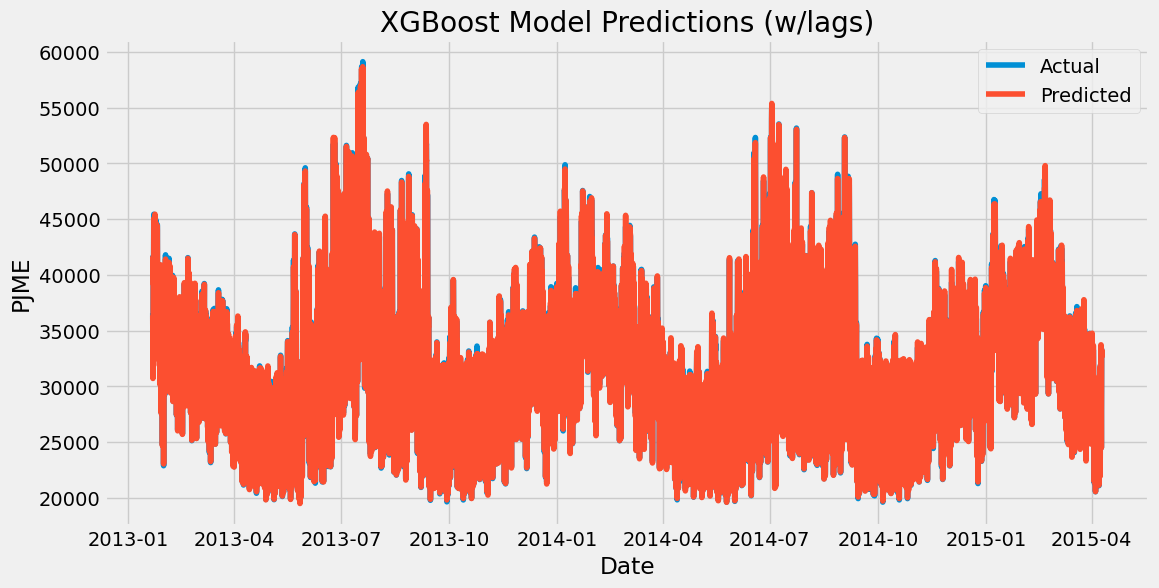

In [758]:
# Plot the actual values and predicted values for the third model
plt.figure(figsize=(12, 6))
plt.plot(y_test3.index, y_test3.values, label='Actual')
plt.plot(y_test3.index, y_pred3, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model Predictions (w/lags)')
plt.legend()
plt.show()

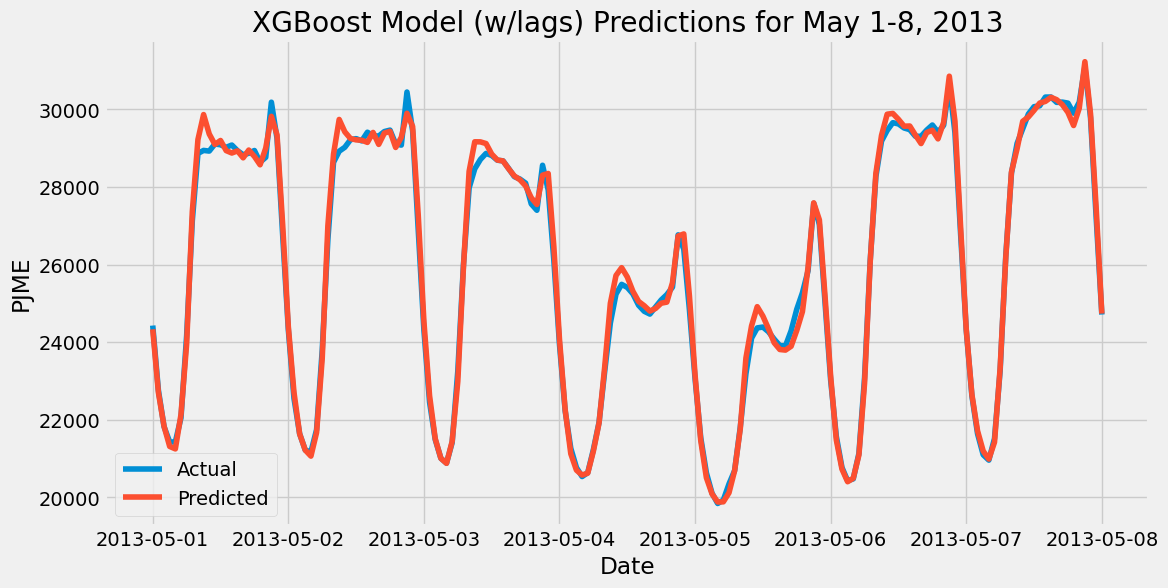

In [759]:
# Looking at one week of data
# Select the data for one week in May 2013
start_date = '2013-05-01'
end_date = '2013-05-08'
mask = (y_test3.index >= start_date) & (y_test3.index <= end_date)
y_test_week3 = y_test3.loc[mask]
y_pred_week3 = pd.Series(y_pred3, index=y_test3.index).loc[mask]

# Plot the actual values and predicted values for one week
plt.figure(figsize=(12, 6))
plt.plot(y_test_week3.index, y_test_week3.values, label='Actual')
plt.plot(y_test_week3.index, y_pred_week3, label='Predicted')
plt.xlabel('Date')
plt.ylabel('PJME')
plt.title('XGBoost Model (w/lags) Predictions for May 1-8, 2013')
plt.legend()
plt.show()

In [760]:
fi3 = pd.DataFrame(data=reg3.feature_importances_,
                index =reg3.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=False)
fi3

,importance
lag_1h,0.940968
hour,0.026706
lag_2h,0.008978
lag_3h,0.007087
lag_1d,0.004639
dayofweek,0.004549
dayofyear,0.002694
month,0.001962
quarter,0.001425
lag_1w,0.000748


### Model # 4 is a hypertuned # 3

In [765]:
try:
    with open('rs_model_cache.pkl', 'rb') as f:
        model = pickle.load(f)
        cached = True
        print("Loaded cached model.")
except FileNotFoundError:
    cached = False

if not cached:
    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag_1h', 'lag_2h', 'lag_3h', 'lag_1d', 'lag_1w']
    TARGET = ['PJME']

    X4 = pjm3_df3[FEATURES]
    y4 = pjm3_df3[TARGET]

    X_train_all4, X_test_all4, y_train_all4, y_test_all4 = train_test_split(X4, y4, test_size=0.2, shuffle=False)

    reg4 = xgb.XGBRegressor()

    param_dist = {
        'n_estimators': [500, 1000],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.5, 0.75],
        'colsample_bytree': [0.5, 0.75]
    }

    tscv4 = TimeSeriesSplit(n_splits=5)

    random_search = RandomizedSearchCV(estimator=reg4, param_distributions=param_dist, cv=tscv4, verbose=3, n_iter=10, random_state=42)
    random_search.fit(X_train_all4, y_train_all4)

    best_params = random_search.best_params_
    print(f"Best Hyperparameters: {best_params}")

    reg4 = xgb.XGBRegressor(random_state=42, **best_params)

    for train_index4, test_index4 in tscv4.split(X_train_all4):
        X_train4, X_test4 = X_train_all4.iloc[train_index4], X_train_all4.iloc[test_index4]
        y_train4, y_test4 = y_train_all4.iloc[train_index4], y_train_all4.iloc[test_index4]

        reg4.fit(X_train4, y_train4,
                eval_set=[(X_train4, y_train4), (X_test4, y_test4)],
                verbose=True)

        y_pred_cv4 = reg4.predict(X_test4)
        mse_cv4 = mean_squared_error(y_test4, y_pred_cv4)
        print(f"Mean Squared Error (CV): {mse_cv4}")

        rmse4 = np.sqrt(mse_cv4)
        print(f"Root Mean Squared Error: {rmse4}")

        mae4 = mean_absolute_error(y_test4, y_pred_cv4)
        print(f"Mean Absolute Error: {mae4}")

    y_pred_holdout4 = reg4.predict(X_test_all4)
    mse_holdout4 = mean_squared_error(y_test_all4, y_pred_holdout4)
    print(f"Holdout Mean Squared Error: {mse_holdout4}")

    rmse_holdout4 = np.sqrt(mse_holdout4)
    print(f"Root Mean Squared Error: {rmse_holdout4}")

    mae_holdout4 = mean_absolute_error(y_test_all4, y_pred_holdout4)
    print(f"Mean Absolute Error: {mae_holdout4}")

    with open('rs_model_cache.pkl', 'wb') as f:
        pickle.dump(reg4, f)
        print("Saved model to cache.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.75;, score=0.996 total time=   7.4s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.75;, score=0.996 total time=  13.4s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.75;, score=0.997 total time=  15.1s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.75;, score=0.997 total time=  18.4s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.75;, score=0.997 total time=  20.0s
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.75;, score=0.996 total time=  10.9s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.75;, score=0.996 total time=  16.8s
[

In [766]:
# Make predictions on the test set
y_pred4 = reg4.predict(X_test_all4)


# Comparing results

In [764]:
# Summary table of the results
results = pd.DataFrame({'Model': ['Model 1', 'Model 2', 'Model 3','RS Hyperparameter Tuned Model 3'],
                        'RMSE': [rmse, rmse2, rmse3, rmse4],
                        'MAE': [mae, mae2, mae3, mae4],
                        'MSE': [mse, mse_cv2, mse_cv3, mse_holdout4],
                        'Holdout RMSE': [rmse_holdout, rmse_holdout2, rmse_holdout3, rmse_holdout4],
                        'Holdout MAE': [mae_holdout, mae_holdout2, mae_holdout3, mae_holdout4],
                        'Holdout MSE': [mse_holdout, mse_holdout2, mse_holdout3, mse_holdout4],
                        'Rows': [len(pjm3_df), len(pjm3_df2), len(pjm3_df3), len(pjm3_df3)]})
results

,Model,RMSE,MAE,MSE,Holdout RMSE,Holdout MAE,Holdout MSE,Rows
0,Model 1,3903.046207,2930.306387,1.523377e+07,3566.607181,2684.735461,1.272069e+07,145366
1,Model 2,3903.046207,2930.306387,1.523377e+07,3566.607181,2684.735461,1.272069e+07,145366
2,Model 3,270.258752,193.812733,7.303979e+04,298.825078,218.356915,8.929643e+04,145366
3,RS Hyperparameter Tuned Model 3,317.689504,233.997387,1.220500e+05,349.356599,260.226653,1.220500e+05,145366
